---
<div align="center">
<h1><span style="color:red;">Surfing the Bitcoin Waves: Comprehensive Trend Forecasting with Various Trader Types</span></h1>
</div>

---
# Authors:
<h3>
<ol>
  <li>Can Ali Ateş - Hacettepe University, Turkey</li>
  <li>Emre Çoban - Hacettepe University, Turkey</li>
</ol>   
</h3>

---
# Problem Definition:
<b></b>
<div style="font-size: 18px;">
    <p>The goal of this project is to thoroughly analyze trends in Bitcoin by studying the behaviors of three key groups:</p>
    <ol>
        <li>Large holders of cryptocurrency (referred to as "whales")</li>
        <li>Influential participants in the stock market (widely recognized as “top traders”)</li>
        <li>Automated trading algorithms (commonly known as "bots")</li>
    </ol>
</div>

---
# Table of Contents

## 1. [Dataset](#1)
    
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>1.1. [Data Explanation](#1.1)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>1.2. [Data Visualization](#1.2)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>1.3. [Data Frame Creation](#1.3)
    
## 2. [Exploratory Data Analysis and Preprocessing](#2)

### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>2.1. [Get Insights](#2.1)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>2.2. [Handling Missing Values](#2.2)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>2.3. [Outlier Analysis](#2.3)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>2.4. [Feature Selection and Engineering](#2.4)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>2.5. [Splitting Data Into Train, Validation and Test](#2.5)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>2.6. [Splitting Target and Input Feature](#2.6)

## 3. [Methodology](#3)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.1. [Machine Learning Models](#3.1)
#### <sub>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.1.1 [Linear Regression Model](#3.1.1)
#### <sub>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.1.2 [Random Forest Regression Model](#3.1.2)
#### <sub>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.1.3 [XGBoost Regression Model](#3.1.3)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.2. [Traditional Forecasting Models](#3.2)
#### <sub>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.2.1 [SARIMAX Model](#3.2.1)
#### <sub>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.2.2 [Prophet Model](#3.2.2)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.3. [Deep Learning Models](#3.3)
#### <sub>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.3.1 [LSTM-FCN Model](#3.3.1)
#### <sub>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.3.2 [TSMixer Model](#3.3.2)
#### <sub>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.3.3 [RESNET-FCN Model](#3.3.3)

In [50]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Methodology
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Model


# Warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

<a id=1></a>
# 1. Dataset

<a id=1.1></a>
## 1.1 Data Explanation

The dataset is a combination of 8 different CSV files.

1. **klines:** The dataset has “Open”, “Close”, “High” and “Low” price features for the Bitcoin stock market.
2. **botTracker:** The dataset has an “estimatedBotCount” feature which indicates the prediction of bot activity based on the searching for frequently occurring unique order sizes.
3. **binanceGlobalAccounts:** The dataset has “Long”, “Short”, and “Ratio of Short and Long” features that represent the total number of accounts that are long or short strategy on Binance.
4. **binanceTopTraderAccounts:** The dataset has “Long”, “Short”, and “Ratio of Short and Long” features that represent the total number of top trader accounts (top %20) that are long or short strategies on Binance.
5. **binanceTopTraderPositions:** The dataset has “Long”, “Short”, and “Ratio of Short and Long” features that represent the total number of top traders positions (top %20) that are long or short strategy on Binance.
6. **binanceWhaleRetailDelta:** The dataset has a “WhaleRetailPositionDelta” feature that indicates the difference between the percentage of long positions held by top trader accounts ("whales") and the percentage of long positions held by global accounts ("retail").
7. **buyVolume:** The dataset has a “BuyingOrderQuantity” feature that indicates the quantity of buying orders executed during a specified period.
8. **sellVolume:** The dataset has a “SellingOrderQuantity” feature that indicates the quantity of selling orders executed during a specified period.

In [23]:
# Define the CSV files
data_files = ["klines", "botTracker", "binanceGlobalAccounts", "binanceTopTraderAccounts", 
              "binanceTopTraderPositions", "binanceWhaleDelta", "buyVolume", "sellVolume"]

<a id=1.2></a>
## 1.2 Data Visualization

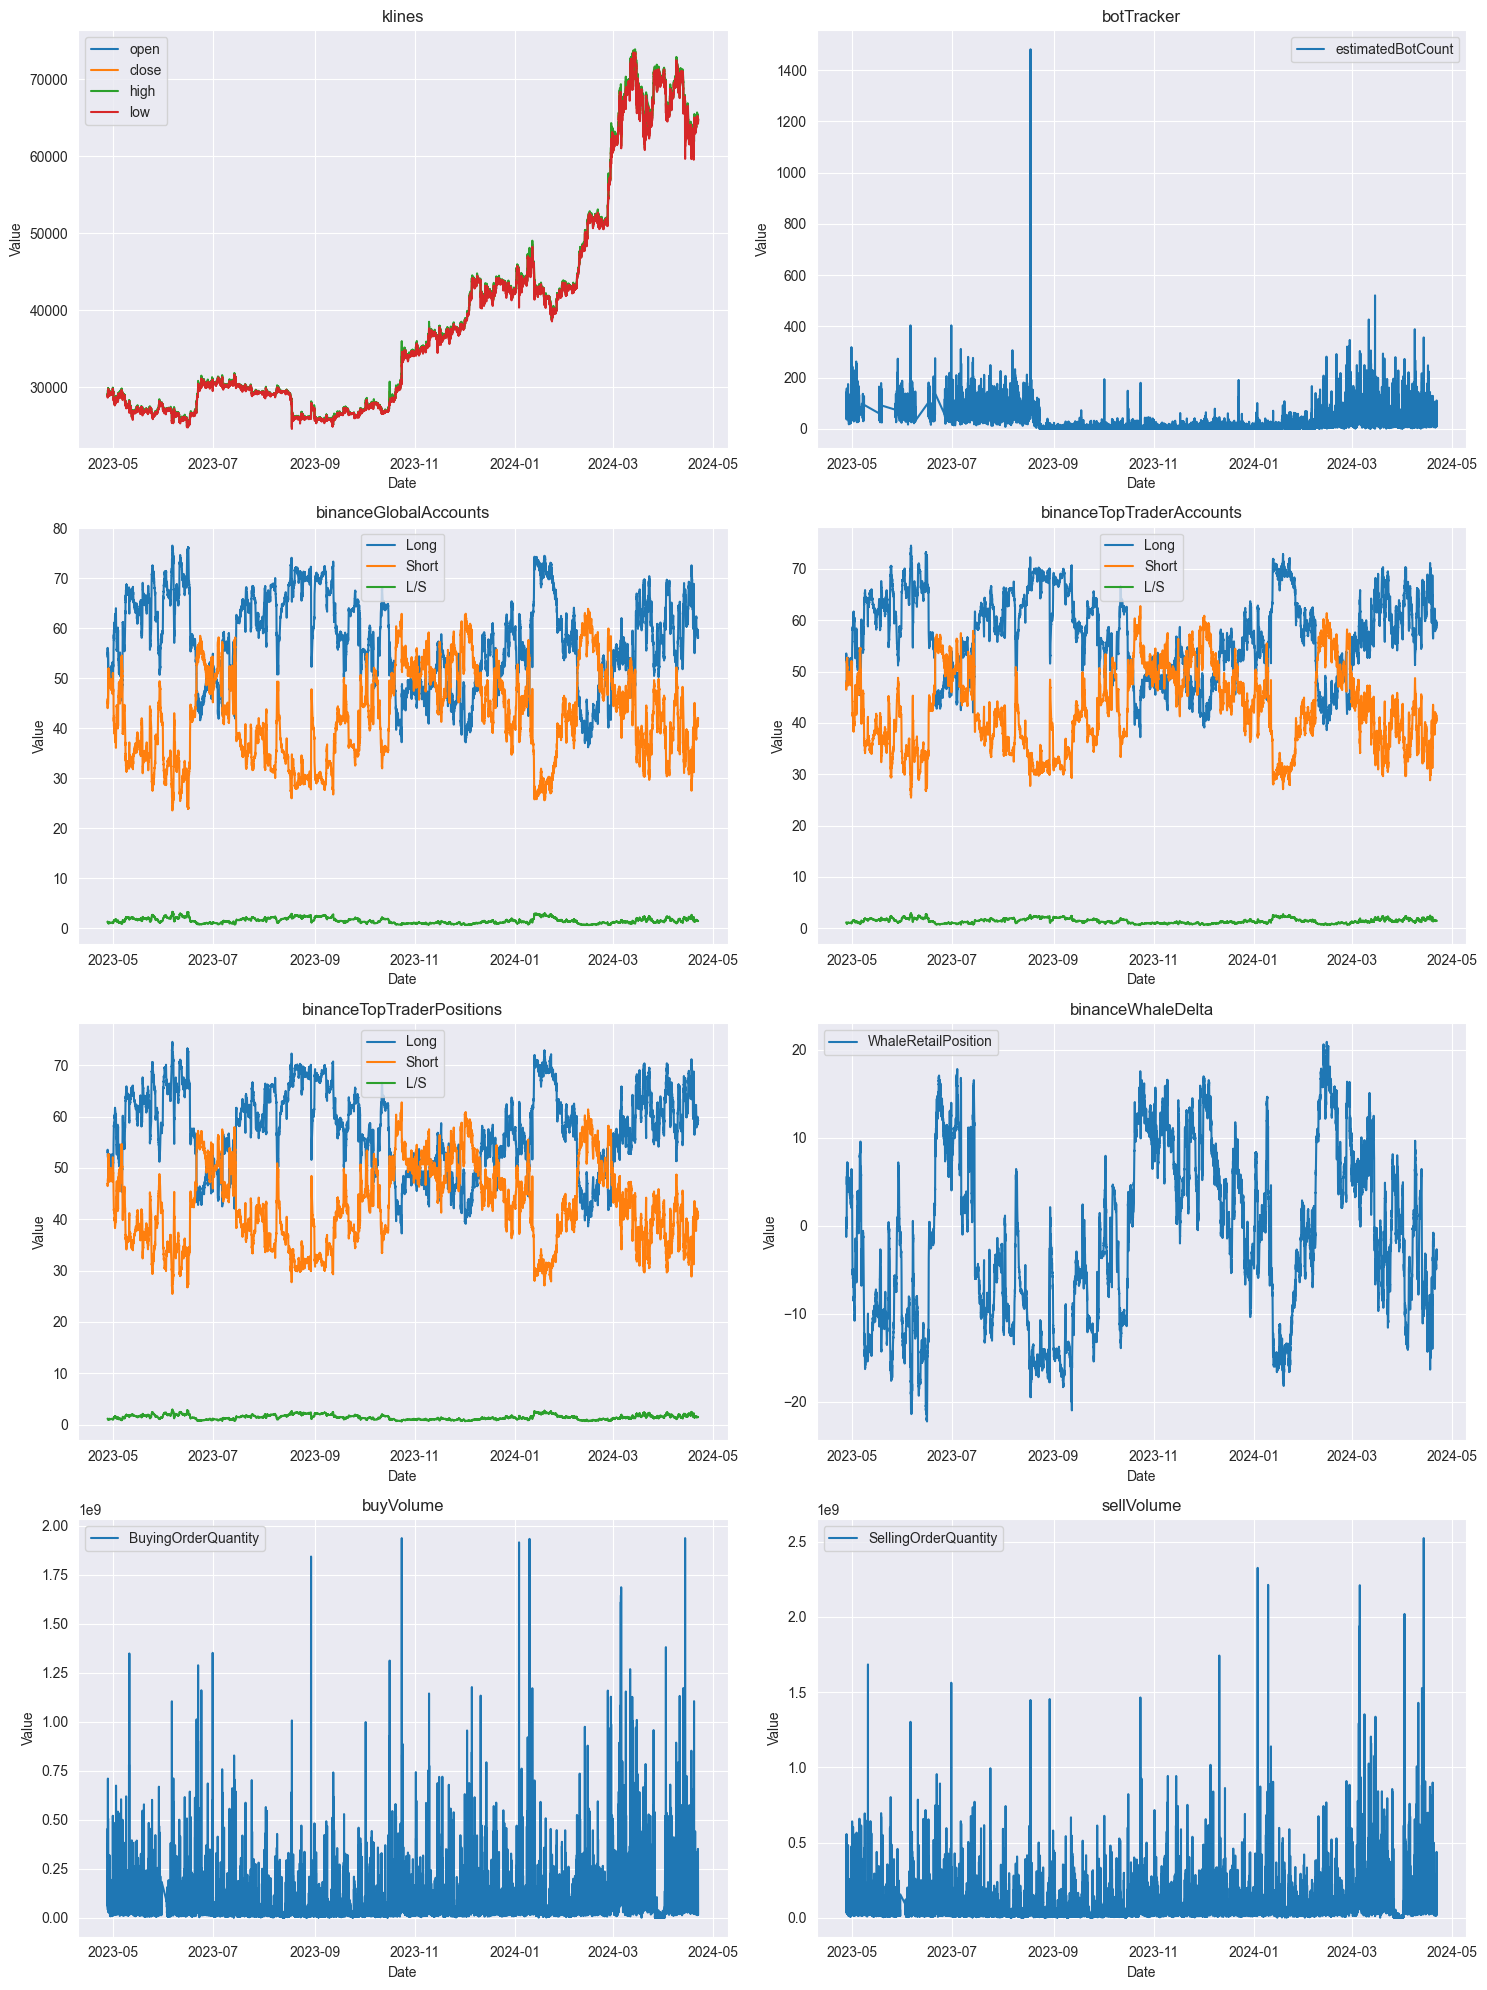

In [24]:
def plot_csv(filename:str, ax:plt.axes):
    # Read the CSV file
    data = pd.read_csv(f"data/{filename}15mins.csv")
    # Convert 'Date' column to datetime
    data['Date'] = pd.to_datetime(data['Date'])
    # Plot the data
    for column in data.columns[1:]:
        ax.plot(data['Date'], data[column], label=column)
    ax.set_title(f'{filename}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()

def plot_data(files:list):
    # Create a subplot grid to plot all data files
    fig, axs = plt.subplots(4, 2, figsize=(15, 20))
    # Iterate over each data file and plot them into subplot grid
    for i, csv_file in enumerate(files):
        plot_csv(filename=csv_file, ax=axs[i // 2, i % 2])
    # Display the plots
    plt.tight_layout()
    plt.show()

plot_data(data_files)

<a id=1.3></a>
## 1.3 Data Frame Creation

In [25]:
# Create a data frame that holds all information in data files
bitcoin_df = pd.DataFrame(columns=['Date'])

# Merge files based on common column
for file in data_files:
    print(file)
    temp_df = pd.read_csv(f"data/{file}15mins.csv")
    temp_df['Date'] = pd.to_datetime(temp_df['Date'])
    bitcoin_df = pd.merge(bitcoin_df, temp_df, on='Date', how="outer")

# Display the data frame
bitcoin_df.set_index("Date", inplace=True)
display(bitcoin_df)

klines
botTracker
binanceGlobalAccounts
binanceTopTraderAccounts
binanceTopTraderPositions
binanceWhaleDelta
buyVolume
sellVolume


,open,close,high,low,estimatedBotCount,Long_x,Short_x,L/S_x,Long_y,Short_y,L/S_y,Long,Short,L/S,WhaleRetailPosition,BuyingOrderQuantity,SellingOrderQuantity
Date,,,,,,,,,,,,,,,,,
2023-04-27 10:15:00+00:00,28959.3,28937.2,29000.0,28930.8,48.0,55.07,44.93,1.2257,53.02,46.98,1.1286,53.02,46.98,1.1286,-0.17,4.311050e+07,5.464228e+07
2023-04-27 10:30:00+00:00,28937.2,29006.8,29019.4,28937.0,44.0,55.04,44.96,1.2242,53.01,46.99,1.1281,53.01,46.99,1.1281,-0.12,5.897624e+07,3.443539e+07
2023-04-27 10:45:00+00:00,29006.8,28981.9,29029.0,28943.0,65.0,55.12,44.88,1.2282,53.05,46.95,1.1299,53.05,46.95,1.1299,-0.23,5.094587e+07,5.778385e+07
2023-04-27 11:00:00+00:00,28981.9,29077.6,29139.2,28960.0,53.0,55.18,44.82,1.2311,53.05,46.95,1.1299,53.05,46.95,1.1299,-0.30,2.054326e+08,1.598568e+08
2023-04-27 11:15:00+00:00,29077.6,29035.3,29084.6,29025.4,119.0,56.03,43.97,1.2743,53.52,46.48,1.1515,53.52,46.48,1.1515,-1.24,6.229194e+07,8.039308e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-21 17:45:00+00:00,64721.3,64793.0,64859.0,64713.4,20.0,58.47,41.53,1.4079,59.31,40.69,1.4576,59.31,40.69,1.4576,-3.10,4.129480e+07,3.586159e+07
2024-04-21 18:00:00+00:00,64793.0,64819.8,64847.7,64600.0,47.0,58.35,41.65,1.4010,59.24,40.76,1.4534,59.24,40.76,1.4534,-2.98,4.500680e+07,7.044362e+07
2024-04-21 18:15:00+00:00,64819.8,64810.0,64819.8,64687.7,39.0,58.17,41.83,1.3906,59.21,40.79,1.4516,59.21,40.79,1.4516,-2.68,3.674641e+07,4.003513e+07


<a id=2></a>
# 2. Exploratory Data Analysis and Preprocessing

In [26]:
# Rename the columns for naming convention
bitcoin_df.rename(columns={"Long_x": "globalAccounts_Long",
                  "Short_x": "globalAccounts_Short",
                  "L/S_x": "globalAccounts_LS",
                  "Long_y": "topTraderAccounts_Long",
                  "Short_y": "topTraderAccounts_Short",
                  "L/S_y": "topTraderAccounts_LS",
                  "Long": "topTraderPositions_Long",
                  "Short": "topTraderPositions_Short",
                  "L/S": "topTraderPositions_LS"},
                  inplace=True)

display(bitcoin_df.head())

,open,close,high,low,estimatedBotCount,globalAccounts_Long,globalAccounts_Short,globalAccounts_LS,topTraderAccounts_Long,topTraderAccounts_Short,topTraderAccounts_LS,topTraderPositions_Long,topTraderPositions_Short,topTraderPositions_LS,WhaleRetailPosition,BuyingOrderQuantity,SellingOrderQuantity
Date,,,,,,,,,,,,,,,,,
2023-04-27 10:15:00+00:00,28959.3,28937.2,29000.0,28930.8,48.0,55.07,44.93,1.2257,53.02,46.98,1.1286,53.02,46.98,1.1286,-0.17,4.311050e+07,5.464228e+07
2023-04-27 10:30:00+00:00,28937.2,29006.8,29019.4,28937.0,44.0,55.04,44.96,1.2242,53.01,46.99,1.1281,53.01,46.99,1.1281,-0.12,5.897624e+07,3.443539e+07
2023-04-27 10:45:00+00:00,29006.8,28981.9,29029.0,28943.0,65.0,55.12,44.88,1.2282,53.05,46.95,1.1299,53.05,46.95,1.1299,-0.23,5.094587e+07,5.778385e+07
2023-04-27 11:00:00+00:00,28981.9,29077.6,29139.2,28960.0,53.0,55.18,44.82,1.2311,53.05,46.95,1.1299,53.05,46.95,1.1299,-0.30,2.054326e+08,1.598568e+08
2023-04-27 11:15:00+00:00,29077.6,29035.3,29084.6,29025.4,119.0,56.03,43.97,1.2743,53.52,46.48,1.1515,53.52,46.48,1.1515,-1.24,6.229194e+07,8.039308e+07


<a id=2.1></a>
## 2.1 Get Insights 

In [27]:
# Get data frame info
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34645 entries, 2023-04-27 10:15:00+00:00 to 2024-04-21 18:45:00+00:00
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   open                      34556 non-null  float64
 1   close                     34556 non-null  float64
 2   high                      34556 non-null  float64
 3   low                       34556 non-null  float64
 4   estimatedBotCount         31376 non-null  float64
 5   globalAccounts_Long       34535 non-null  float64
 6   globalAccounts_Short      34535 non-null  float64
 7   globalAccounts_LS         34535 non-null  float64
 8   topTraderAccounts_Long    34532 non-null  float64
 9   topTraderAccounts_Short   34532 non-null  float64
 10  topTraderAccounts_LS      34532 non-null  float64
 11  topTraderPositions_Long   34532 non-null  float64
 12  topTraderPositions_Short  34532 non-null  float64
 13  topTraderPosit

In [28]:
# Describe the data frame
bitcoin_df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
open,34556.0,3.870601e+04,1.389279e+04,24803.0000,2.747807e+04,3.384460e+04,4.366677e+04,7.369010e+04
close,34556.0,3.870723e+04,1.389374e+04,24804.1000,2.747805e+04,3.384505e+04,4.366707e+04,7.369010e+04
high,34556.0,3.877141e+04,1.393646e+04,24917.9000,2.752205e+04,3.391520e+04,4.372985e+04,7.388140e+04
low,34556.0,3.863796e+04,1.384659e+04,24581.0000,2.743295e+04,3.377965e+04,4.359468e+04,7.348000e+04
estimatedBotCount,31376.0,3.178120e+01,3.906006e+01,0.0000,4.000000e+00,1.500000e+01,5.025000e+01,1.481000e+03
globalAccounts_Long,34535.0,5.763517e+01,8.930339e+00,36.1500,5.071000e+01,5.773000e+01,6.512500e+01,7.649000e+01
globalAccounts_Short,34535.0,4.236483e+01,8.930339e+00,23.5100,3.487500e+01,4.227000e+01,4.929000e+01,6.385000e+01
globalAccounts_LS,34535.0,1.472252e+00,5.436524e-01,0.5662,1.028800e+00,1.365700e+00,1.867400e+00,3.253500e+00
topTraderAccounts_Long,34532.0,5.730141e+01,7.819026e+00,37.2300,5.098000e+01,5.768000e+01,6.354000e+01,7.456000e+01
topTraderAccounts_Short,34532.0,4.269859e+01,7.819026e+00,25.4400,3.646000e+01,4.232000e+01,4.902000e+01,6.277000e+01


<a id=2.2></a>
## 2.2 Handling Missing Values 

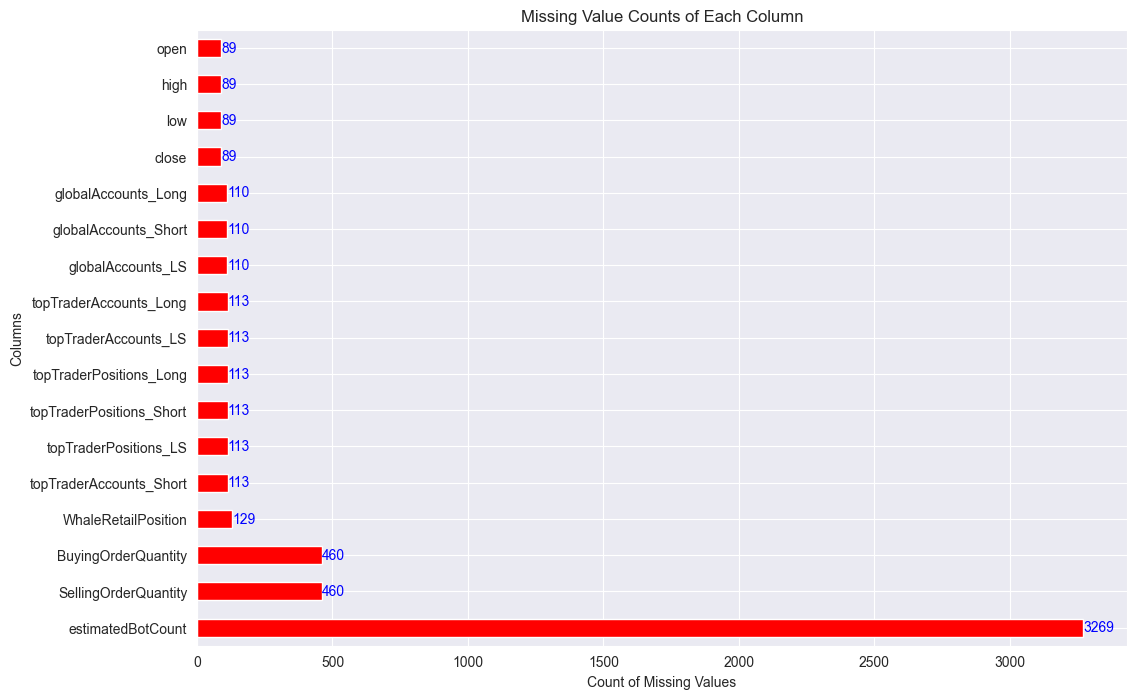

In [29]:
def visualize_missing_value_counts(df=bitcoin_df):
    # Plot bar chart to display missing value counts of features
    plt.figure(figsize=(12, 8))
    missing_values = df.isnull().sum().sort_values(ascending=False)
    missing_values.plot(kind='barh', color='red')
    
    # Adding instance count on the graph
    for i, v in enumerate(missing_values):
        plt.text(v + 1, i, str(v), color='blue', va='center')
    
    # Plot NaN value graph
    plt.xlabel('Count of Missing Values')
    plt.ylabel('Columns')
    plt.title('Missing Value Counts of Each Column')
    plt.show()

visualize_missing_value_counts()

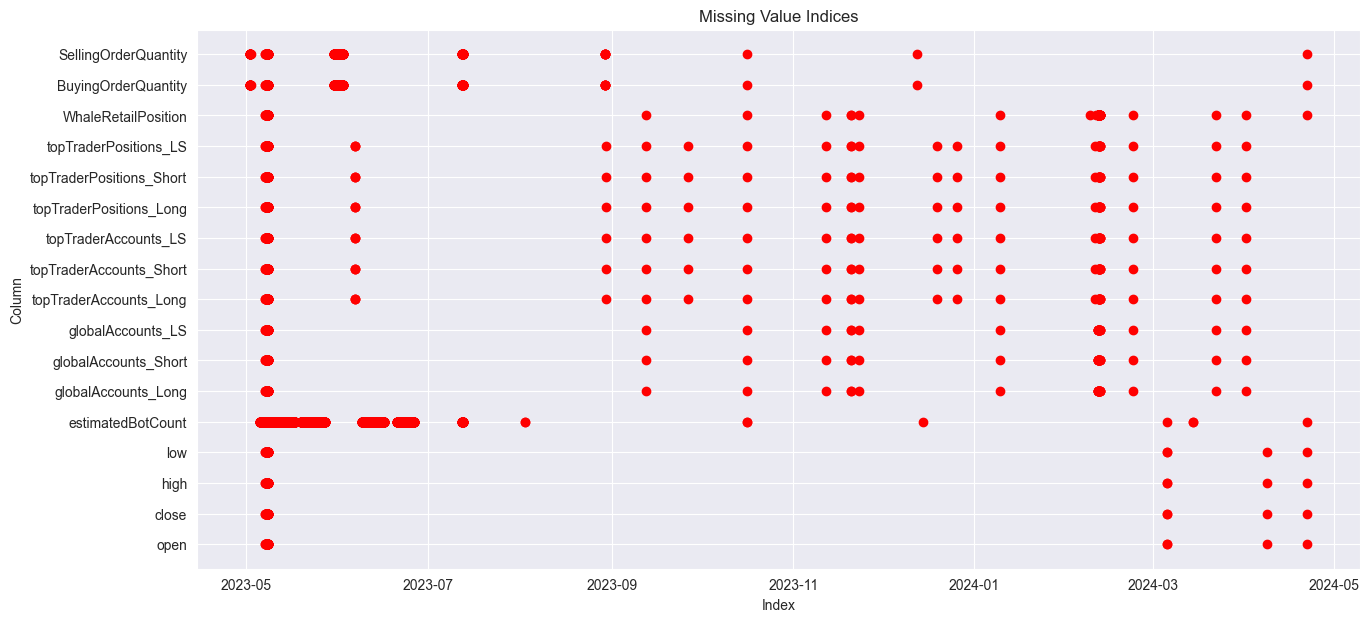

In [30]:
def visualize_missing_value_indexes(df=bitcoin_df):
    # Create a DataFrame to store missing value indices
    missing_indices = df.isnull().astype(int)
    
    # Plot missing value indices
    plt.figure(figsize=(15, 7))
    y_missing, y_non_missing = [], []
    for i, column in enumerate(df.columns):
        missing_values = missing_indices[column][missing_indices[column] == 1].index
        non_missing_values = missing_indices[column][missing_indices[column] == 0].index
        y_missing.extend([i] * len(missing_values))
        y_non_missing.extend([i + 0.5] * len(non_missing_values))
        plt.scatter(missing_values, [i] * len(missing_values), marker='o', color='red', label='Missing Values' if i == 0 else None)
    
    plt.yticks(range(len(df.columns)), df.columns)
    plt.title('Missing Value Indices')
    plt.xlabel('Index')
    plt.ylabel('Column')
    plt.show()

visualize_missing_value_indexes()

- **The API returns NaN when the system does not detect any bot at this interval, therefore we will fill the NaN values with 0 in the estimatedBotCount**
- **Most of the features have same consecutive NaN values at the end, therefore drop these rows**
- **Impute remain features with the linear interpolation**

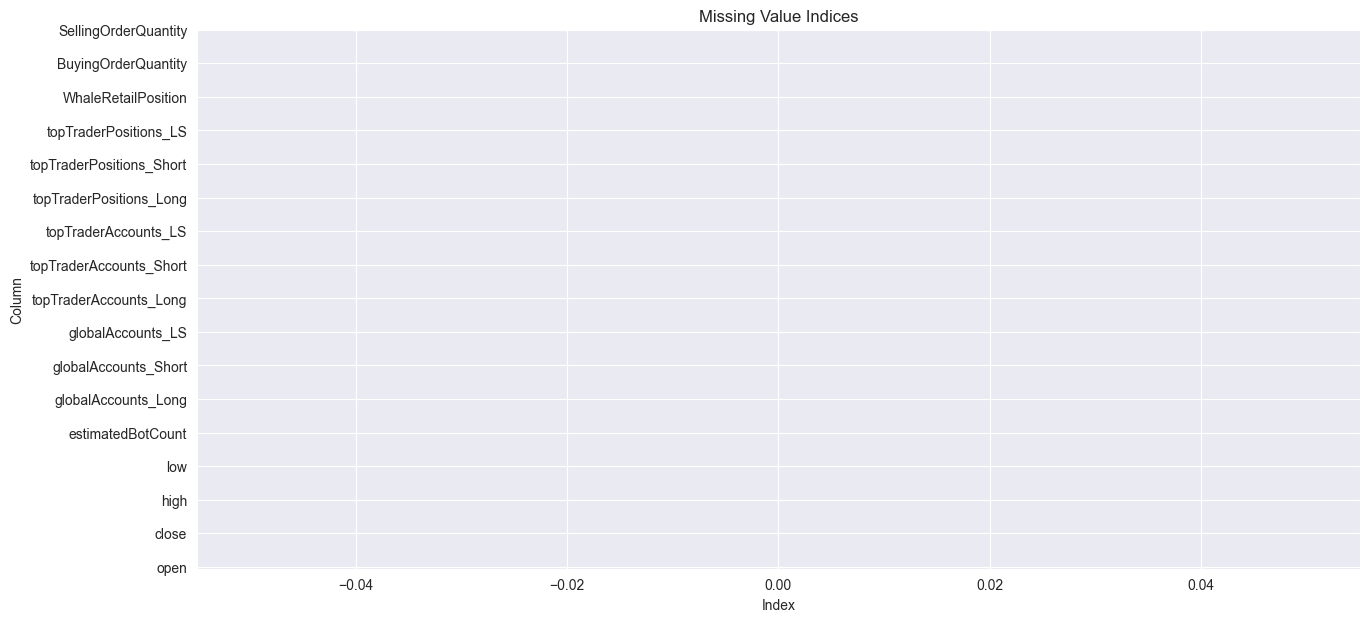

In [31]:
# Impute the NaN values of estimatedBotCount with 0
bitcoin_df.fillna({'estimatedBotCount': 0}, inplace=True)
# Choose the NaN values at the end using "open" feature as guidance
bitcoin_df.dropna(subset=["open"], inplace=True)
# Impute remain NaN values with linear interpolation
bitcoin_df.interpolate(method="linear", axis=0, inplace=True)

# Display NaN value counts after missing value handling
visualize_missing_value_indexes()

<a id=2.3></a>
## 2.3 Outlier Analysis

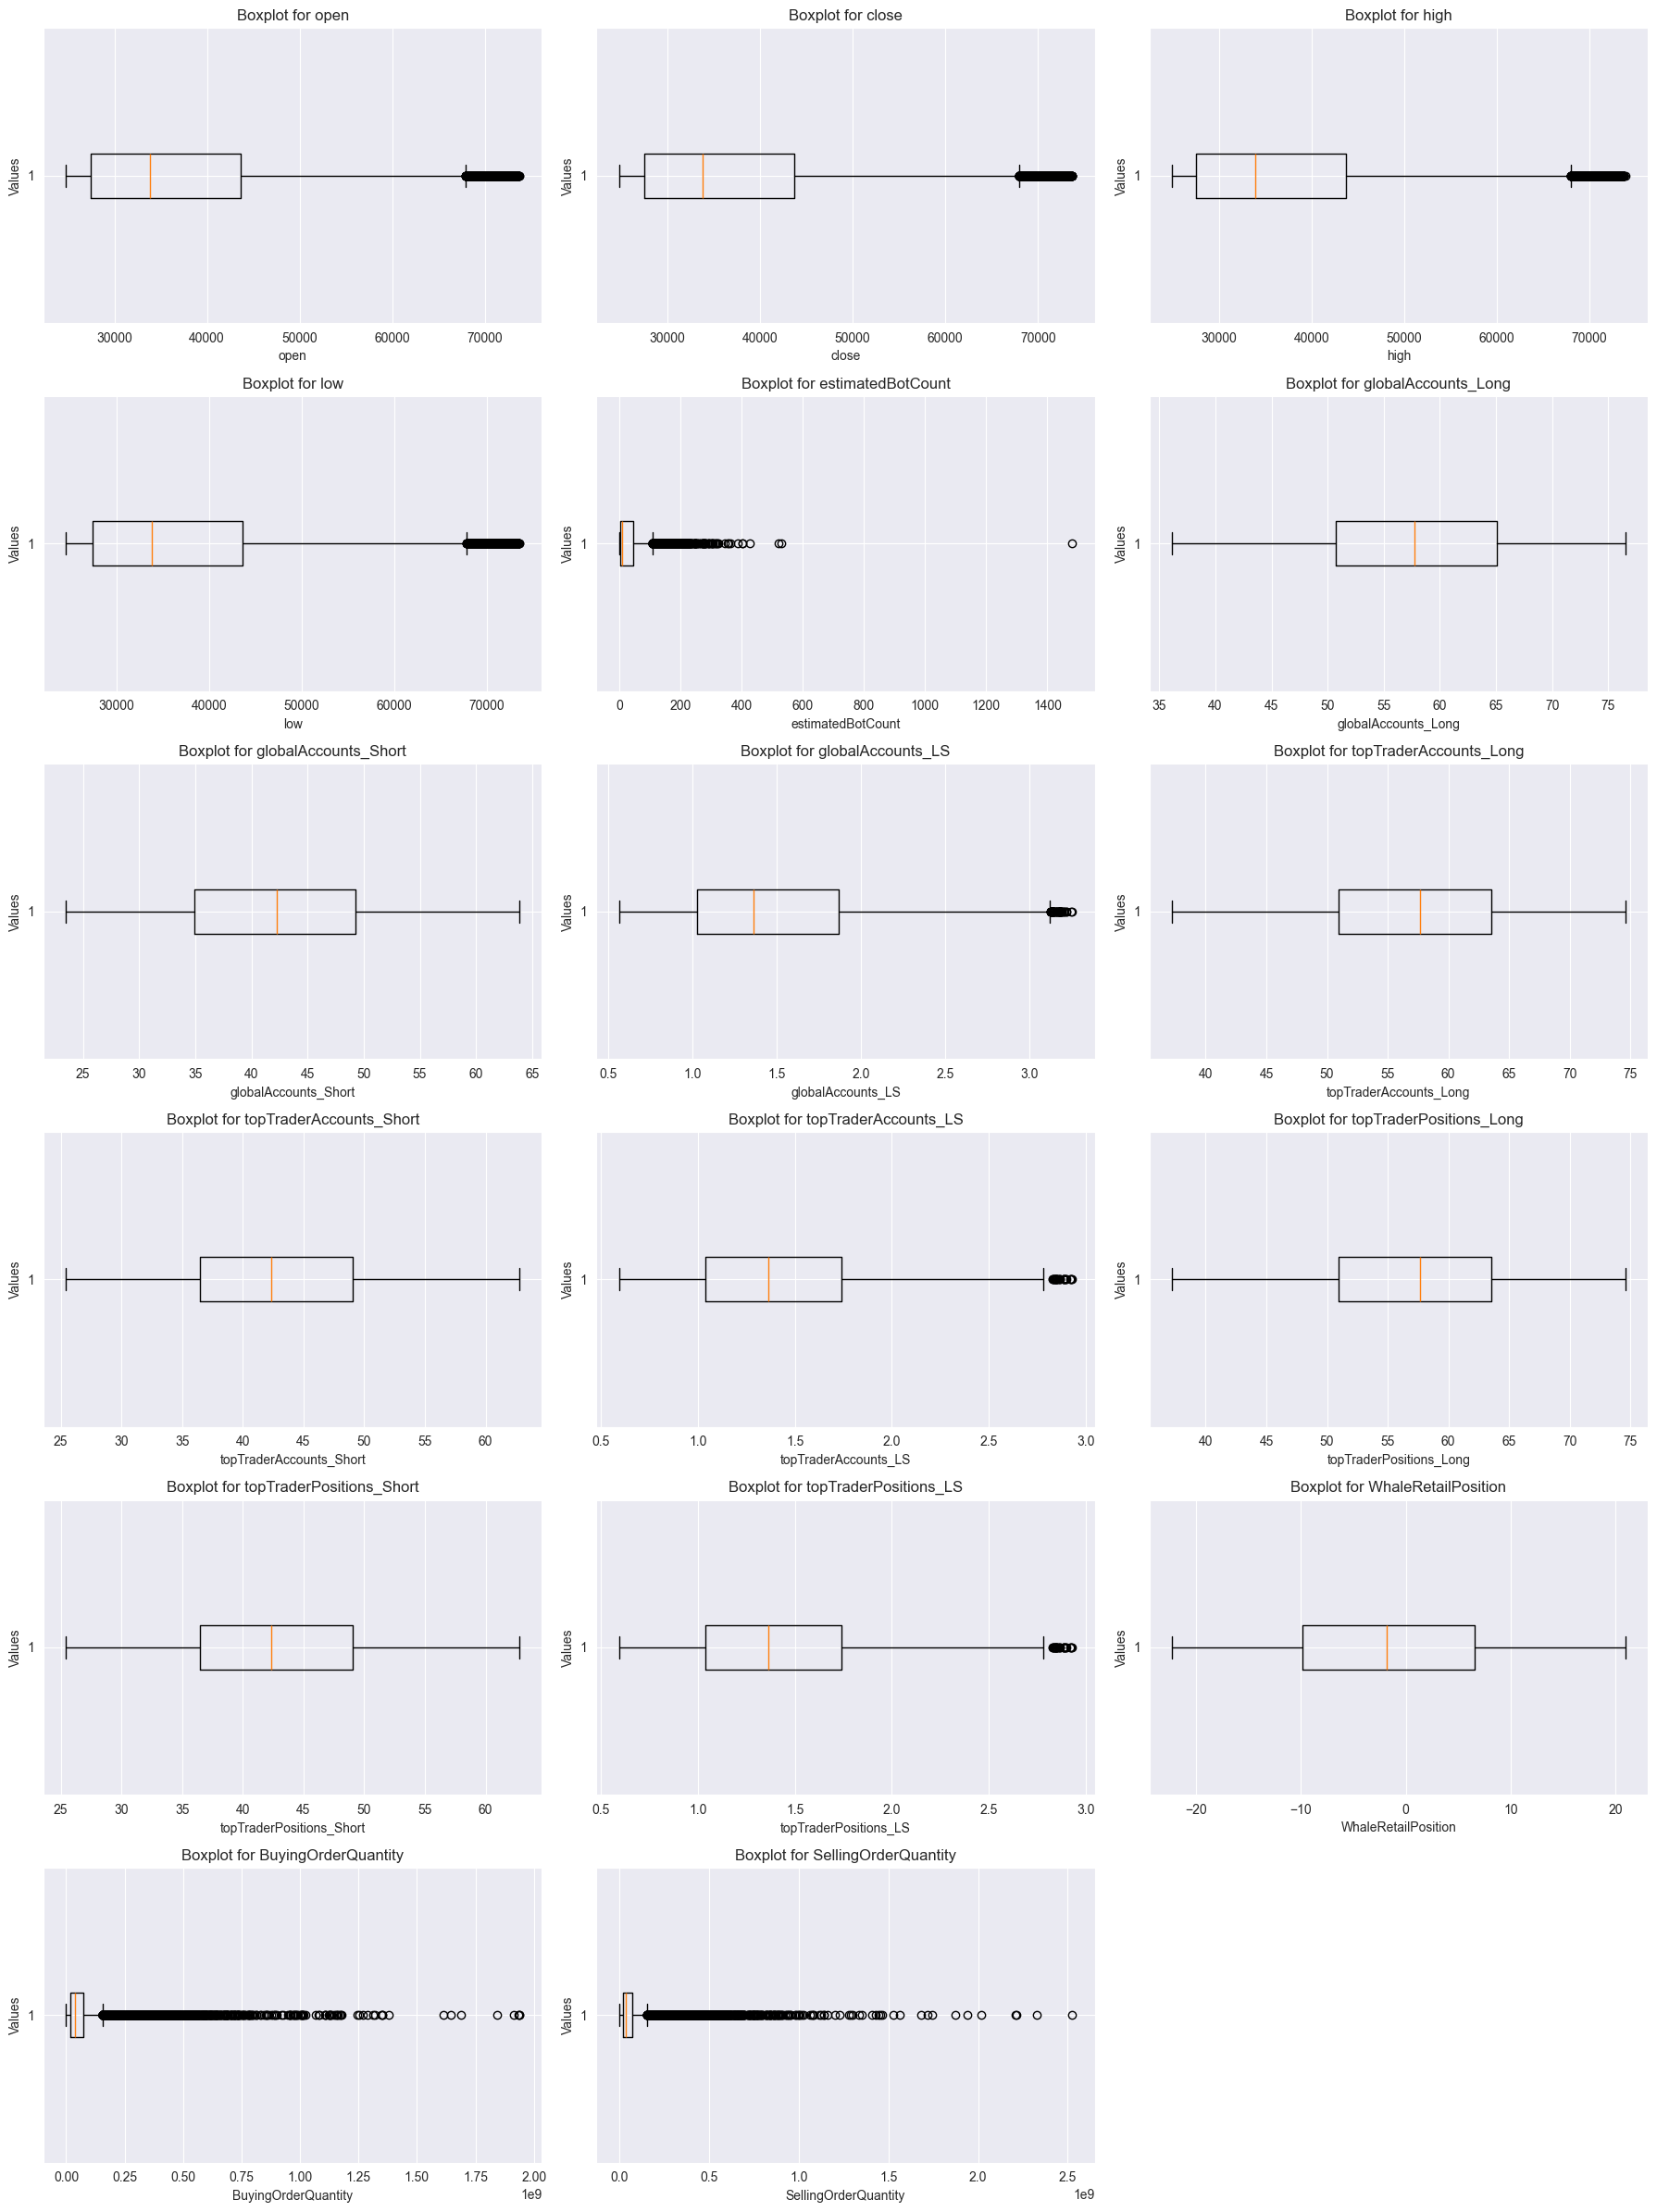

In [32]:
# Create a 6x3 grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(18, 24))

# Flatten the axes array
axes = axes.flatten()

# Plot each column in a separate subplot
for i, column in enumerate(bitcoin_df.columns):
    axes[i].boxplot(bitcoin_df[column], vert=False)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Values')
    axes[i].set_title(f'Boxplot for {column}')

# Hide any extra subplots
for j in range(len(bitcoin_df.columns), len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

**The boxplot figure demonstrated that some of the features have outliers but data that used for the project is time-series so, these points can be extrema. However, these outliers provide valuable insights into extreme market conditions and trading behaviors, while respecting the inherent volatility of cryptocurrency markets. Therefore, the outliers will be protected instead of dropping or smoothing them.**

<a id=2.4></a>
## 2.4 Feature Selection and Engineering

In [33]:
# Drop the features that have LS feature which represent the Long-Short ratio
bitcoin_df.drop(columns=["globalAccounts_Long", "globalAccounts_Short",
                         "topTraderAccounts_Long", "topTraderAccounts_Short",
                         "topTraderPositions_Long", "topTraderPositions_Short"], inplace=True)

# Check first 5 row of feature selected dataframe
display(bitcoin_df.head())

,open,close,high,low,estimatedBotCount,globalAccounts_LS,topTraderAccounts_LS,topTraderPositions_LS,WhaleRetailPosition,BuyingOrderQuantity,SellingOrderQuantity
Date,,,,,,,,,,,
2023-04-27 10:15:00+00:00,28959.3,28937.2,29000.0,28930.8,48.0,1.2257,1.1286,1.1286,-0.17,4.311050e+07,5.464228e+07
2023-04-27 10:30:00+00:00,28937.2,29006.8,29019.4,28937.0,44.0,1.2242,1.1281,1.1281,-0.12,5.897624e+07,3.443539e+07
2023-04-27 10:45:00+00:00,29006.8,28981.9,29029.0,28943.0,65.0,1.2282,1.1299,1.1299,-0.23,5.094587e+07,5.778385e+07
2023-04-27 11:00:00+00:00,28981.9,29077.6,29139.2,28960.0,53.0,1.2311,1.1299,1.1299,-0.30,2.054326e+08,1.598568e+08
2023-04-27 11:15:00+00:00,29077.6,29035.3,29084.6,29025.4,119.0,1.2743,1.1515,1.1515,-1.24,6.229194e+07,8.039308e+07


<a id=2.5></a>
## 2.5 Splitting Data Into Train, Validation and Test

In [34]:
def train_val_split(df, train_ratio = 0.9, val_ratio = 0.05):

    # Determine the sizes of each set
    total_samples = len(df)
    train_size = int(total_samples * 0.9)  # 90% for training
    val_size = int(total_samples * 0.05)   # 5% for validation
    test_size = total_samples - train_size - val_size # 5% for testing

    # Split the DataFrame
    train_df = df.iloc[:train_size]
    val_df = df.iloc[train_size:train_size + val_size]
    test_df = df.iloc[train_size + val_size:]

    return train_df, val_df, test_df


bitcoin_df.index = pd.to_datetime(bitcoin_df.index)
bitcoin_df = bitcoin_df.asfreq('15min')
bitcoin_df.interpolate(method="linear", axis=0, inplace=True)  # NaN values due to mismatch in time frequency using interpolation (35 per feature)

train_df, val_df, test_df = train_val_split(bitcoin_df)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 31134
Validation set size: 1729
Test set size: 1731


<a id=2.6></a>
## 2.6 Splitting Target and Input Features

In [35]:
# Training set

X_train = train_df.drop(columns=['close'])
y_train = train_df['close']

# Validation set
X_val = val_df.drop(columns=['close'])
y_val = val_df['close']

# Test set
X_test = test_df.drop(columns=['close'])
y_test = test_df['close']

In [36]:
X_train.index[0],  X_val.index[0], X_test.index[0]

(Timestamp('2023-04-27 10:15:00+0000', tz='UTC'),
 Timestamp('2024-03-16 17:45:00+0000', tz='UTC'),
 Timestamp('2024-04-03 18:00:00+0000', tz='UTC'))

<a id=3></a>
# 3. METHODOLOGY

In [37]:
# Window generator
def sliding_window_generator(x_df, y_df, window_size, step_size, forecast_horizon=1):
    """
    Generate sliding windows from two pandas DataFrames.

    Args:
        x_df (pandas.DataFrame): Input DataFrame.
        y_df (pandas.DataFrame): Output DataFrame.
        window_size (int): Size of the sliding window.
        step_size (int): Step size for sliding the window.
        forecast_horizon (int): Number of steps to forecast into the future.

    Returns:
        tuple: Tuple containing two numpy.ndarrays:
               - seq_x: Input sequences
               - seq_y: Corresponding output sequences
    """
    x_data = x_df.values
    y_data = y_df.values
    num_samples = len(x_data)
    seq_x, seq_y = [], []
    for i in range(0, num_samples - window_size - forecast_horizon + 1, step_size):
        x_window = x_data[i:i + window_size]
        y_window = y_data[i + window_size:i + window_size + forecast_horizon]
        seq_x.append(x_window)  # Input sequence
        seq_y.append(y_window)  # Corresponding output
    return np.array(seq_x), np.array(seq_y)

# for drawing predictions vs truth graph.
def plot_predictions(truth, preds):
    plt.figure(figsize=(10, 6))
    plt.plot(truth, label='Actual', color='blue')
    plt.plot(preds, label='Predicted', color='red')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Test Predictions vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

<a id=3.1></a>
## 3.1 Machine Learning Models

<a id=3.1.1></a>
### 3.1.1 Linear Regression Model

In [54]:
# Generate sliding window data
train_seq_x, train_seq_y = sliding_window_generator(X_train, y_train, window_size=1, step_size=1,forecast_horizon=1)
val_seq_x, val_seq_y = sliding_window_generator(X_val, y_val,  window_size=1, step_size=1,forecast_horizon=1)
test_seq_x, test_seq_y = sliding_window_generator(X_test, y_test,  window_size=1, step_size=1,forecast_horizon=1)

# Initialize Linear Regressor
lin_reg = LinearRegression()

# Train the Linear Regression model
lin_reg.fit(train_seq_x.reshape(len(train_seq_x), -1), train_seq_y)

# Make predictions on the test set
y_pred_lin = lin_reg.predict(test_seq_x.reshape(len(test_seq_x), -1))

In [55]:
# Calculate RMSE on the test set
rmse_test_lin = np.sqrt(mean_squared_error(y_pred_rf, test_seq_y))
print("Linear Regression Root Mean Squared Error (RMSE) of Test Data (Optimized):", rmse_test_lin)

Linear Regression Root Mean Squared Error (RMSE) of Test Data (Optimized): 251.35646600787163


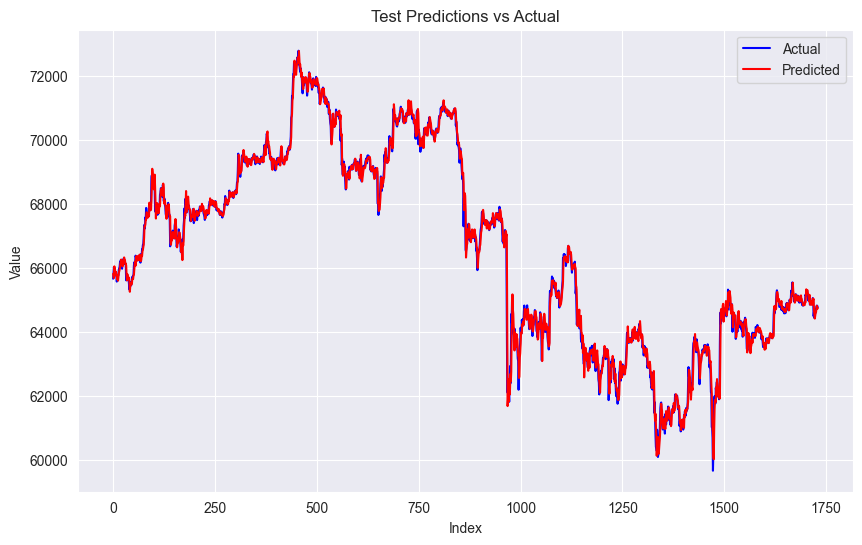

In [56]:
plot_predictions(test_seq_y, y_pred_lin)

<a id=3.1.2></a>
### 3.1.2 Random Forest Regression Model

In [40]:
# Generate sliding window data
train_seq_x, train_seq_y = sliding_window_generator(X_train, y_train, window_size=1, step_size=1,forecast_horizon=1)
val_seq_x, val_seq_y = sliding_window_generator(X_val, y_val,  window_size=1, step_size=1,forecast_horizon=1)
test_seq_x, test_seq_y = sliding_window_generator(X_test, y_test,  window_size=1, step_size=1,forecast_horizon=1)

# Initialize Random Forest regressor
rf_reg = RandomForestRegressor(
    n_estimators=50,
    max_depth=25,
    min_samples_split=18,
    min_samples_leaf=10,
    random_state=42
)

# Train the Random Forest model
rf_reg.fit(train_seq_x.reshape(len(train_seq_x), -1), train_seq_y)

# Make predictions on the test set
y_pred_rf = rf_reg.predict(test_seq_x.reshape(len(test_seq_x), -1))

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [41]:
# Calculate RMSE on the test set
rmse_test_rf = np.sqrt(mean_squared_error(y_pred_rf, test_seq_y))
print("Random Forest Root Mean Squared Error (RMSE) of Test Data (Optimized):", rmse_test_rf)

Random Forest Root Mean Squared Error (RMSE) of Test Data (Optimized): 291.2733786139135


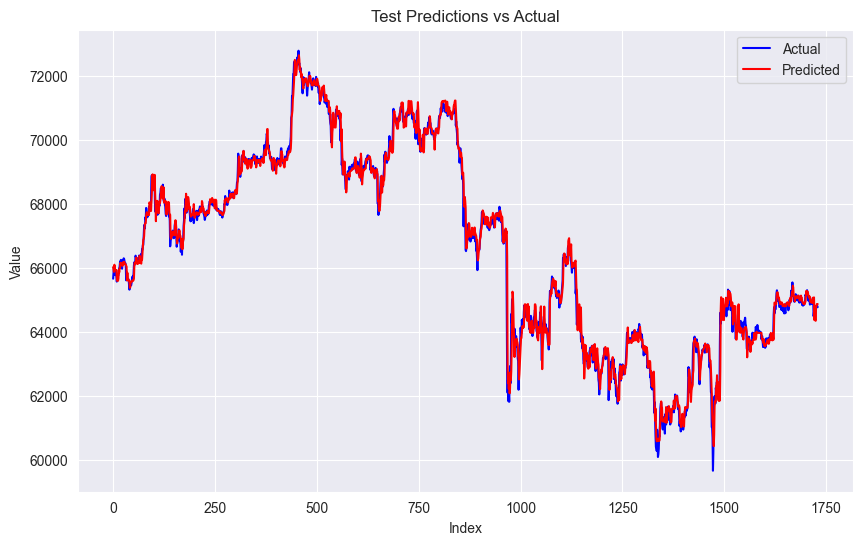

In [42]:
plot_predictions(test_seq_y, y_pred_rf)

<a id=3.1.3></a>
### 3.1.3 XGBoost Regression Model

In [76]:
# Generate sliding window data
train_seq_x, train_seq_y = sliding_window_generator(X_train, y_train, 1, 1)
val_seq_x, val_seq_y = sliding_window_generator(X_val, y_val, 1, 1)
test_seq_x, test_seq_y = sliding_window_generator(X_test, y_test, 1, 1)

# Initialize XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=42,
                           early_stopping_rounds=25)

# Train the XGBoost model with early stopping based on the validation set
xgb_reg.fit(train_seq_x.reshape(len(train_seq_x), -1), train_seq_y,
             eval_set=[(val_seq_x.reshape(len(val_seq_x), -1), val_seq_y)], verbose=0)

# Make predictions on the test set
y_pred = xgb_reg.predict(test_seq_x.reshape(len(test_seq_x), -1))

In [77]:
# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_pred, test_seq_y))
print("XGBoost Root Mean Squared Error (RMSE) of Test Data:", rmse_test)

XGBoost Root Mean Squared Error (RMSE) of Test Data: 626.2435774425818


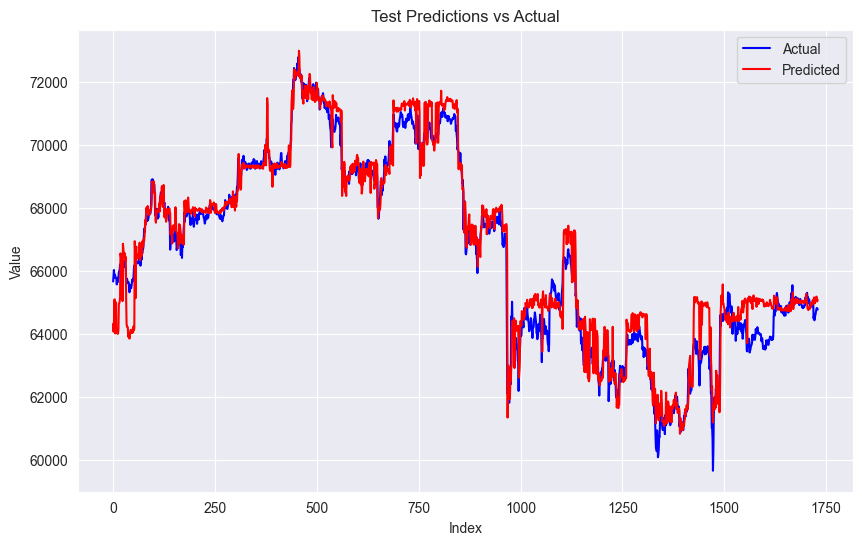

In [78]:
plot_predictions(test_seq_y, y_pred)

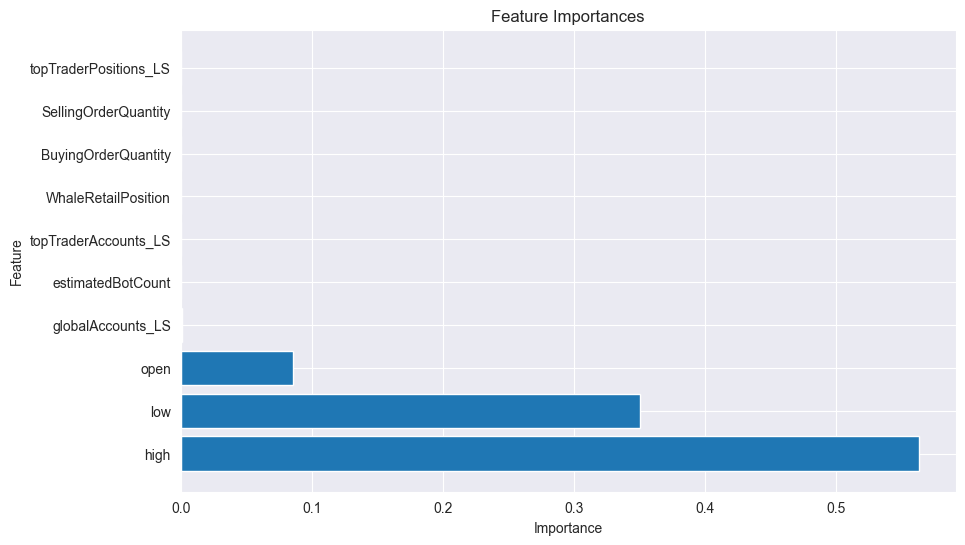

In [79]:
# Get feature names from X_test (assuming X_test is a pandas DataFrame)
feature_names = X_test.columns.tolist()

# Get feature importances and zip them with feature names
feature_importances = xgb_reg.feature_importances_
feature_importances_with_names = list(zip(feature_names, feature_importances))

# Sort feature importances by importance value
feature_importances_with_names.sort(key=lambda x: x[1], reverse=True)

# Visualize feature importances
importance_df = pd.DataFrame(feature_importances_with_names, columns=['Feature', 'Importance'])
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


<a id=3.2></a>
## 3.2 Traditional Forecasting Models

<a id=3.2.1></a>
### 3.2.1 SARIMAX (Seasonal Autoregressive Integrated Moving Average Exogenous) Model

In [26]:
# Get the best orders, including both non-seasonal and seasonal orders
stepwise_fit = auto_arima(y=y_train, seasonal=True)
best_order = stepwise_fit.order
best_seasonal_order = stepwise_fit.seasonal_order
print(f"Best order: {best_order}")
print(f"Best seasonal order: {best_seasonal_order}")

Best order: (5, 2, 0)
Best seasonal order: (0, 0, 0, 0)


In [47]:
# Train the model
order = (2, 1, 4)  # Example non-seasonal orders (p, d, q)
seasonal_order = (0, 0, 0, 0)  # Example seasonal orders (P, D, Q, m)
model = SARIMAX(
        y_train,
        exog=X_train,
        order=order,
        seasonal_order=seasonal_order
    )
model = model.fit()

In [48]:
# Make predictions on the validation data starting from the first timestamp of y_val
y_test_pred = model.forecast(exog=X_test, steps=len(X_test))

# Calculate Root Mean Squared Error (MSE) on the validation set
mse_val = ((y_test - y_test_pred) ** 2).mean()
print(f"SARIMAX Root Mean Squared Error (RMSE) of Test Data:: {np.sqrt(mse_val)}")

SARIMAX Root Mean Squared Error (RMSE) of Test Data:: 278.2598592592185


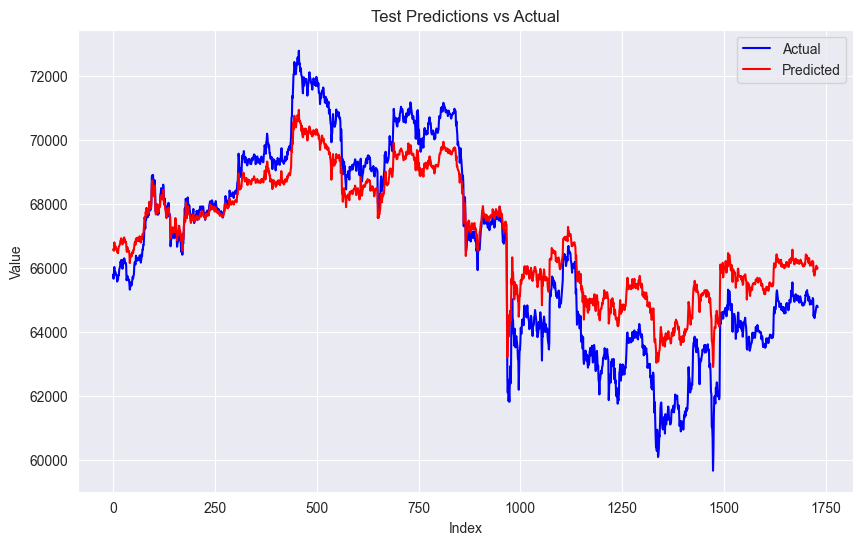

In [49]:
plot_predictions(np.array(y_test), np.array(y_test_pred))

<a id=3.2.2 Prophet></a>
### 3.2.2 Prophet Model

In [55]:
# Copy original train_df to use further
prophet_df = train_df.copy()

In [56]:
# Preprocess the train data for prophet model
prophet_train = train_df.rename(columns={"close": "y"})
prophet_train["ds"] = train_df.index.tz_localize(None)
prophet_train.reset_index(drop=True, inplace=True)

# Use log-domain for prophet model
prophet_train["y_original"] = prophet_train["y"].copy()
prophet_train["y"] = np.log(prophet_train["y"])

# Display train data for prophet model
prophet_train.head(5)

,open,y,high,low,estimatedBotCount,globalAccounts_LS,topTraderAccounts_LS,topTraderPositions_LS,WhaleRetailPosition,BuyingOrderQuantity,SellingOrderQuantity,ds,y_original
0,28959.3,10.272883,29000.0,28930.8,48.0,1.2257,1.1286,1.1286,-0.17,4.311050e+07,5.464228e+07,2023-04-27 10:15:00,28937.2
1,28937.2,10.275286,29019.4,28937.0,44.0,1.2242,1.1281,1.1281,-0.12,5.897624e+07,3.443539e+07,2023-04-27 10:30:00,29006.8
2,29006.8,10.274427,29029.0,28943.0,65.0,1.2282,1.1299,1.1299,-0.23,5.094587e+07,5.778385e+07,2023-04-27 10:45:00,28981.9
3,28981.9,10.277723,29139.2,28960.0,53.0,1.2311,1.1299,1.1299,-0.30,2.054326e+08,1.598568e+08,2023-04-27 11:00:00,29077.6
4,29077.6,10.276268,29084.6,29025.4,119.0,1.2743,1.1515,1.1515,-1.24,6.229194e+07,8.039308e+07,2023-04-27 11:15:00,29035.3


In [57]:
# Build and train model
prophet_model = Prophet()

regressor_list = ['open', 'high', 'low', 'estimatedBotCount', 'globalAccounts_LS', 'topTraderAccounts_LS', 
                  'topTraderPositions_LS', 'WhaleRetailPosition', 'BuyingOrderQuantity', 'SellingOrderQuantity']

for regressor in regressor_list:
    prophet_model.add_regressor(regressor)

prophet_model.fit(prophet_train)

22:23:28 - cmdstanpy - INFO - Chain [1] start processing
22:23:49 - cmdstanpy - INFO - Chain [1] done processing


In [58]:
# Preprocess the test data to use for Prophet model
prophet_df = pd.concat([prophet_df, test_df], ignore_index=False)
prophet_df = prophet_df.rename(columns={"close": "y"})
prophet_df["ds"] = prophet_df.index.tz_localize(None)
prophet_df.reset_index(drop=True, inplace=True)

# Create future data for Prophet model
future_data = prophet_model.make_future_dataframe(periods=96, freq="15min")
future_data = prophet_df[['open', 'high', 'low', 'estimatedBotCount', 'globalAccounts_LS', 'topTraderAccounts_LS', 
                          'topTraderPositions_LS', 'WhaleRetailPosition', 'BuyingOrderQuantity', 'SellingOrderQuantity', 
                          'ds']]

future_data.head(5)

,open,high,low,estimatedBotCount,globalAccounts_LS,topTraderAccounts_LS,topTraderPositions_LS,WhaleRetailPosition,BuyingOrderQuantity,SellingOrderQuantity,ds
0,28959.3,29000.0,28930.8,48.0,1.2257,1.1286,1.1286,-0.17,4.311050e+07,5.464228e+07,2023-04-27 10:15:00
1,28937.2,29019.4,28937.0,44.0,1.2242,1.1281,1.1281,-0.12,5.897624e+07,3.443539e+07,2023-04-27 10:30:00
2,29006.8,29029.0,28943.0,65.0,1.2282,1.1299,1.1299,-0.23,5.094587e+07,5.778385e+07,2023-04-27 10:45:00
3,28981.9,29139.2,28960.0,53.0,1.2311,1.1299,1.1299,-0.30,2.054326e+08,1.598568e+08,2023-04-27 11:00:00
4,29077.6,29084.6,29025.4,119.0,1.2743,1.1515,1.1515,-1.24,6.229194e+07,8.039308e+07,2023-04-27 11:15:00


In [59]:
# Forecasting with test data
prophet_forecast_data = prophet_model.predict(future_data)

# Display the last 5 predictions
prophet_forecast_data[['open', 'high', 'low', 'estimatedBotCount', 'globalAccounts_LS', 'topTraderAccounts_LS', 
               'topTraderPositions_LS', 'WhaleRetailPosition', 'BuyingOrderQuantity', 'SellingOrderQuantity', 
               'ds']].tail(5)

,open,high,low,estimatedBotCount,globalAccounts_LS,topTraderAccounts_LS,topTraderPositions_LS,WhaleRetailPosition,BuyingOrderQuantity,SellingOrderQuantity,ds
32860,-0.152891,0.333316,0.365006,-0.000014,-0.002165,-0.001331,-0.001331,-0.002076,0.000073,0.000197,2024-04-21 17:30:00
32861,-0.153337,0.334127,0.366236,0.000059,-0.001796,-0.001460,-0.001460,-0.002422,-0.000505,0.000516,2024-04-21 17:45:00
32862,-0.153714,0.333998,0.364815,-0.000160,-0.002056,-0.001360,-0.001360,-0.002279,-0.000416,-0.000145,2024-04-21 18:00:00
32863,-0.153855,0.333679,0.365914,-0.000095,-0.002447,-0.001317,-0.001317,-0.001922,-0.000614,0.000436,2024-04-21 18:15:00
32864,-0.153803,0.333567,0.366284,0.000124,-0.002466,-0.001374,-0.001374,-0.002041,-0.001133,0.000756,2024-04-21 18:30:00


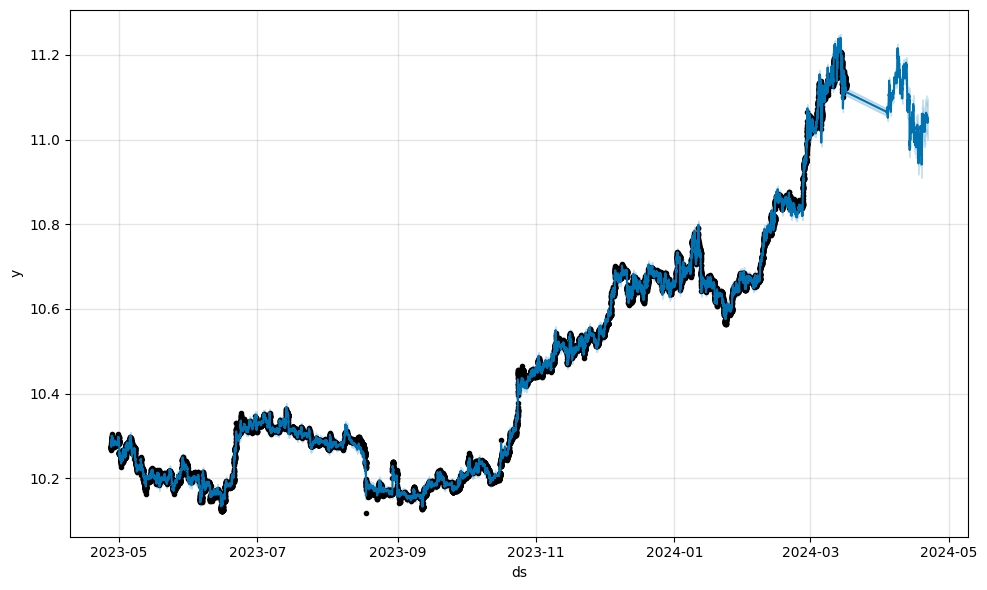

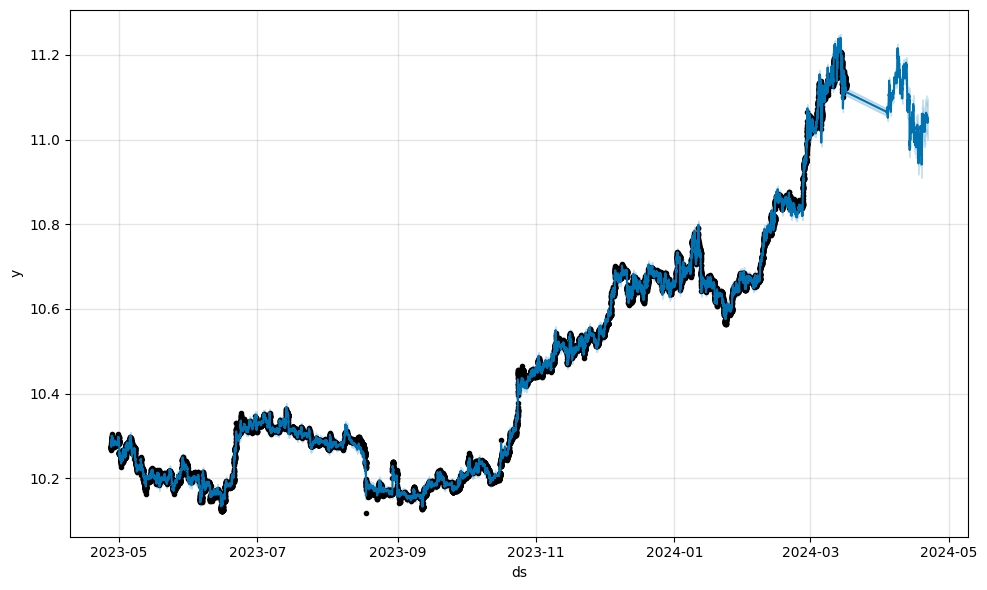

In [60]:
# Plot the information from Prophet model
prophet_model.plot(prophet_forecast_data)

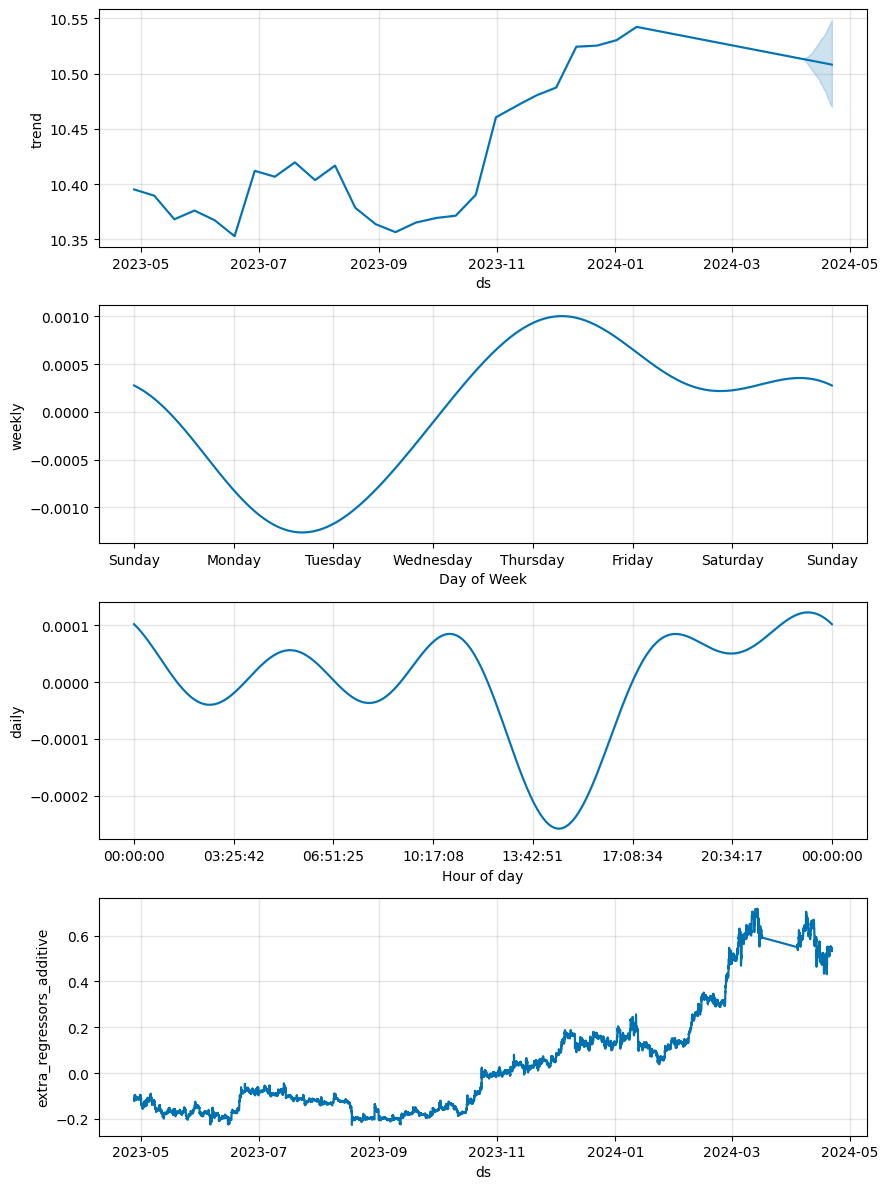

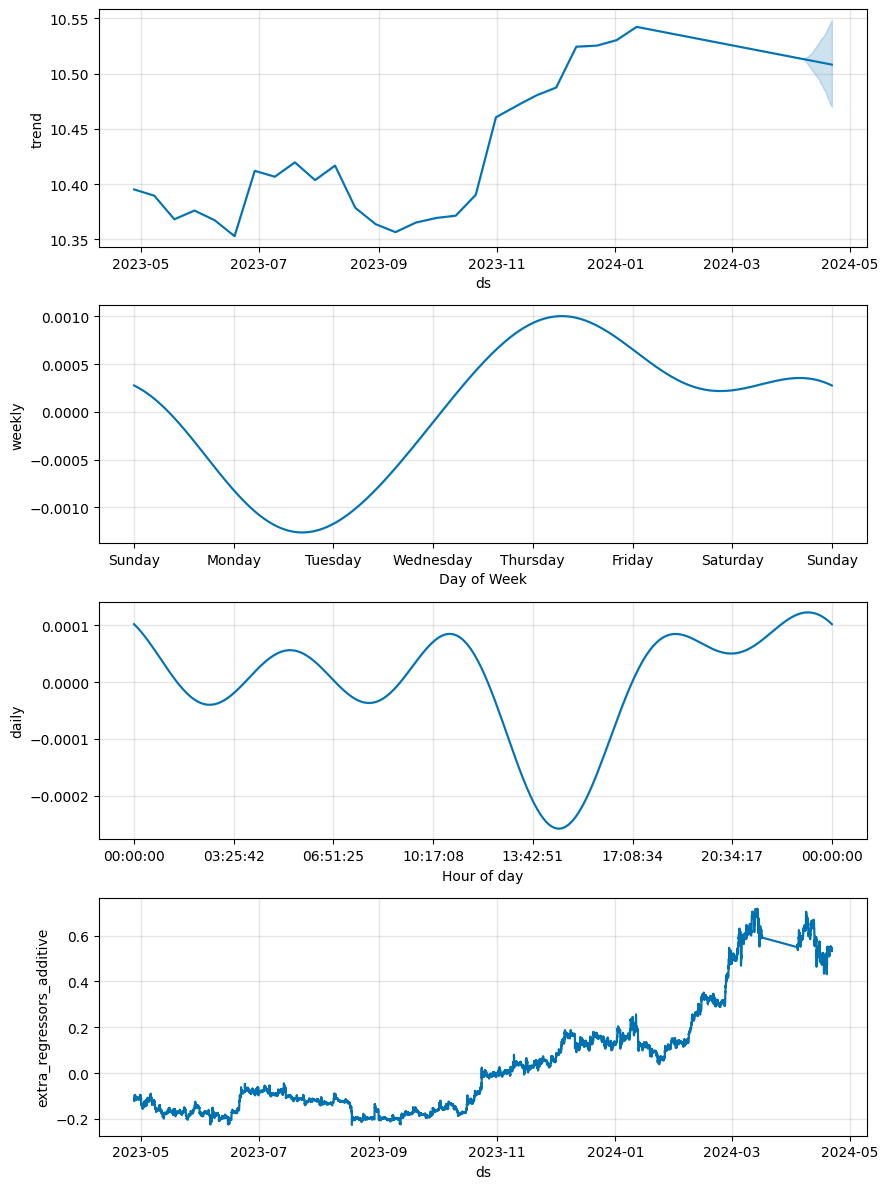

In [61]:
# Plot the Prophet model components
prophet_model.plot_components(prophet_forecast_data)

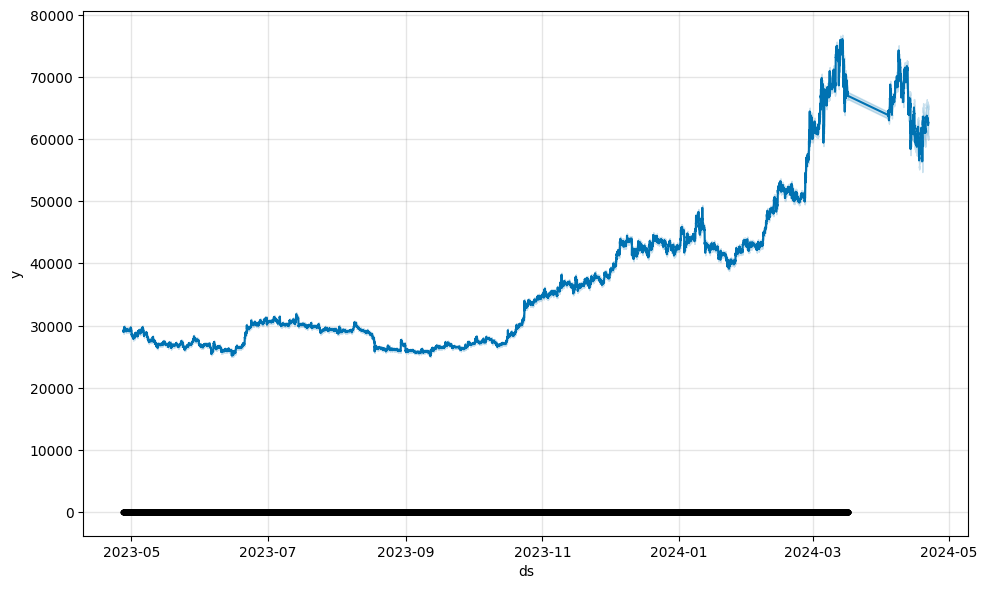

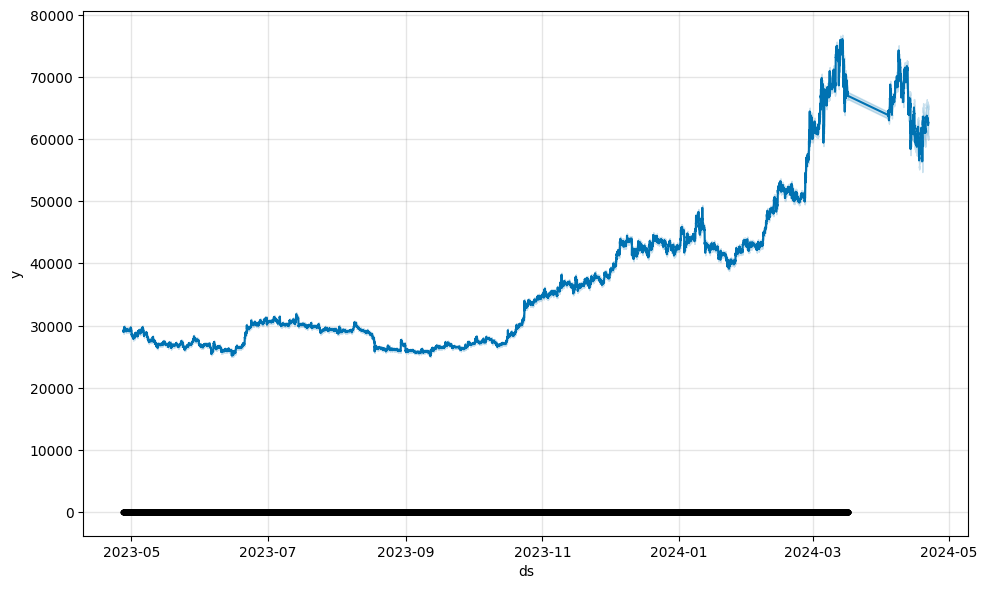

In [66]:
# Correct the log domain with exponential
prophet_forecast_data_original = prophet_forecast_data.copy()
prophet_forecast_data_original["yhat"] = np.exp(prophet_forecast_data_original["yhat"])
prophet_forecast_data_original["yhat_lower"] = np.exp(prophet_forecast_data_original["yhat_lower"])
prophet_forecast_data_original["yhat_upper"] = np.exp(prophet_forecast_data_original["yhat_upper"])
prophet_result_df = pd.DataFrame(prophet_forecast_data_original)

# Plot the exact prophet results without log domain
prophet_model.plot(prophet_forecast_data_original)

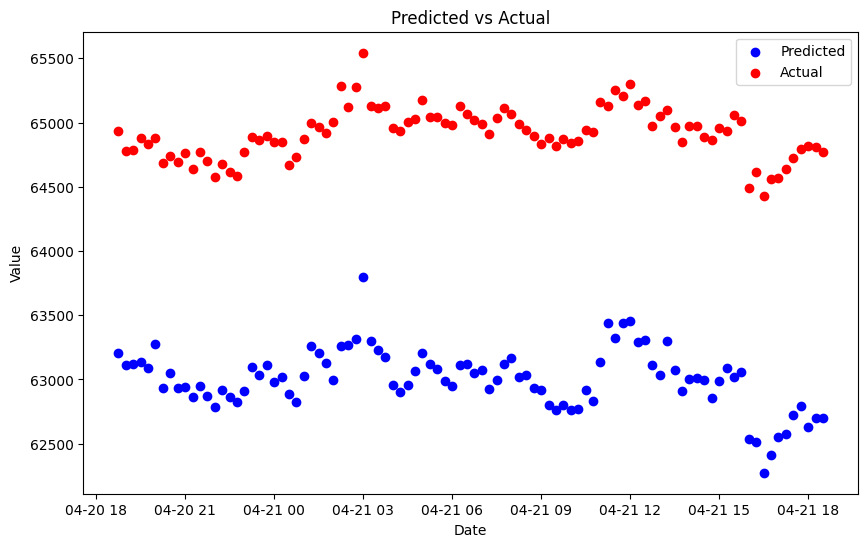

In [67]:
# Plot the forecasting results of Prophet model
plt.figure(figsize=(10, 6))
plt.scatter(prophet_result_df.iloc[-96:]["ds"], prophet_result_df.iloc[-96:]["yhat"], label="Predicted", color="blue")
plt.scatter(prophet_result_df.iloc[-96:]["ds"], test_df["close"].iloc[-96:], label="Actual", color="red")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Predicted vs Actual")
plt.legend()
plt.show()

In [68]:
# Calculate Root Mean Squared Error (RMSE)
mse = mean_squared_error(prophet_result_df.iloc[-96:]["yhat"], test_df["close"].iloc[-96:])

print("Root Mean Squared Error (RMSE):", np.sqrt(mse))

Root Mean Squared Error (RMSE): 1916.5396046147325


<a id=3.3></a>
## 3.3 Deep Learning Models

<a id=3.3.1></a>
### 3.3.1 LSTM-FCN

In [24]:
class LSTM_FCN_Model:

    def __init__(self, input_shape, num_classes, lstm_units=256, conv_filters=128, kernel_size=7):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.lstm_units = lstm_units
        self.conv_filters = conv_filters
        self.kernel_size = kernel_size

    def build_model(self):
        inputs = tf.keras.layers.Input(shape=self.input_shape)

        # LSTM layer
        lstm_out = tf.keras.layers.LSTM(self.lstm_units)(inputs)
        lstm_out = tf.keras.layers.Dropout(0.25)(lstm_out)

        # Permute layer
        permute_out = tf.keras.layers.Permute((2, 1))(inputs)

        # Convolutional layers
        conv_out = tf.keras.layers.Conv1D(self.conv_filters, self.kernel_size, padding='same', kernel_initializer='he_uniform')(permute_out)
        conv_out = tf.keras.layers.BatchNormalization()(conv_out)
        conv_out = tf.keras.layers.Activation('gelu')(conv_out)

        # Global average pooling layer
        conv_out = tf.keras.layers.GlobalAveragePooling1D()(conv_out)

        # Concatenate LSTM and Convolutional outputs
        combined_out = tf.keras.layers.concatenate([lstm_out, conv_out])

        # Output layer
        outputs = tf.keras.layers.Dense(self.num_classes)(combined_out)

        # Create model
        model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

        return model

In [26]:
# Define parameters
window_size = 12
step_size = 1
input_shape = (window_size, 10)  # Define num_features
num_classes = 1  # regression problem

# Generate sliding window data
train_seq_x, train_seq_y = sliding_window_generator(X_train, y_train, window_size, step_size)
val_seq_x, val_seq_y = sliding_window_generator(X_val, y_val, window_size, step_size)
test_seq_x, test_seq_y = sliding_window_generator(X_test, y_test, window_size, step_size)


# Initialize and build the model
model = LSTM_FCN_Model(input_shape, num_classes).build_model()

# Define early stopping and learning rate scheduler callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=5, verbose=1, min_lr=1e-7)


optimizer = tf.optimizers.Adam(learning_rate=1e-2)
# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

# Train the model
history = model.fit(train_seq_x, train_seq_y, validation_data=(val_seq_x, val_seq_y), epochs=200, batch_size=64,
                    callbacks=[early_stopping, lr_scheduler], verbose=1)

# Evaluate the model
test_preds = model.predict(test_seq_x)
test_loss = model.evaluate(test_seq_x, test_seq_y, verbose=0)

print("Root Mean Squared Error of Test Data:", np.sqrt(test_loss))

Epoch 1/200
487/487 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1325243904.0000 - mse: 1325243904.0000 - val_loss: 3459368448.0000 - val_mse: 3459368448.0000 - learning_rate: 0.0100
Epoch 2/200
487/487 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 663854272.0000 - mse: 663854272.0000 - val_loss: 1692496512.0000 - val_mse: 1692496512.0000 - learning_rate: 0.0100
Epoch 3/200
487/487 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 167450688.0000 - mse: 167450688.0000 - val_loss: 987393664.0000 - val_mse: 987393664.0000 - learning_rate: 0.0100
Epoch 4/200
487/487 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 96236856.0000 - mse: 96236856.0000 - val_loss: 771163776.0000 - val_mse: 771163776.0000 - learning_rate: 0.0100
Epoch 5/200
487/487 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 60623160.0000 - mse: 60623160.0000 - val_loss: 253469456.0000 - val_mse: 253469456.0000 - learning_rate: 0.0100
Epoch 6/200
487/487 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 30077252.0000 - mse: 30077252.0000 - val_loss: 83857304.

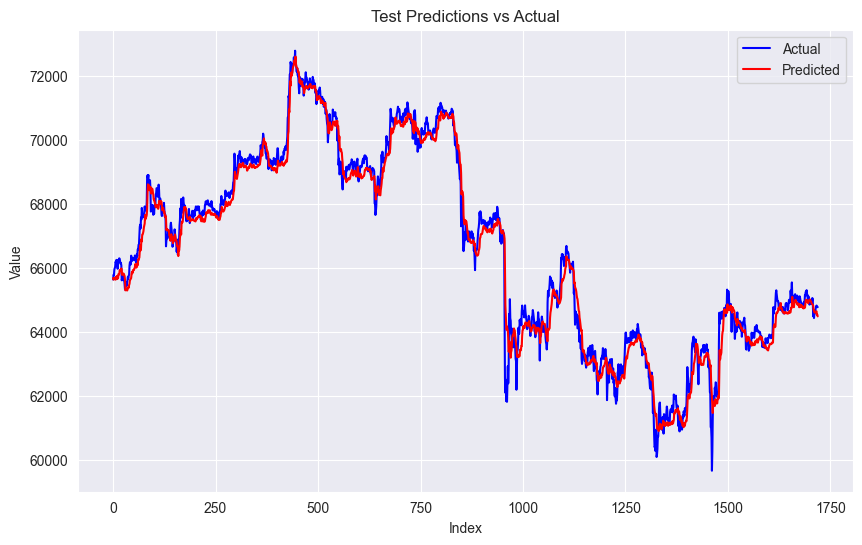

In [27]:
plot_predictions(test_seq_y, test_preds)

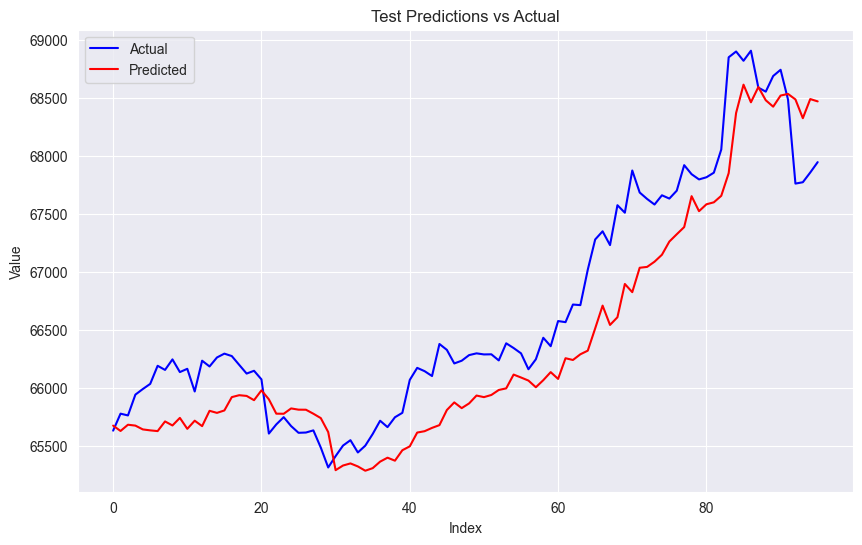

In [28]:
# First days prediction
plot_predictions(test_seq_y[:96], test_preds[:96])

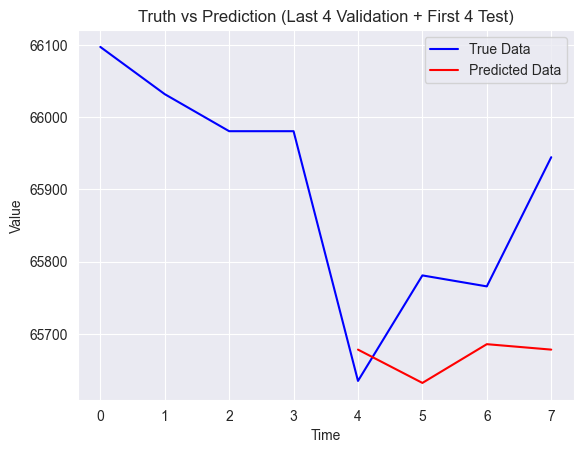

In [49]:
# Extracting the last 4 values of the validation sequence
val_last_4 = val_seq_y[-4:]

# Extracting the first 4 values of the test sequence
test_first_4 = test_seq_y[:4]

# Concatenating the last 4 values of the validation sequence with the first 4 values of the test sequence
truth_combined = np.concatenate((val_last_4, test_first_4), axis=0)

# Extracting the last 4 predicted values
pred_last_4 = test_preds[:4]

# Plotting
plt.plot(range(8), truth_combined, label='True Data', color='blue')
plt.plot(range(4, 8), pred_last_4, label='Predicted Data', color='red')

# Adding labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Truth vs Prediction (Last 4 Validation + First 4 Test)')
plt.legend()

# Show plot
plt.show()

<a id=3.3.2></a>
### 3.3.2 TSMixer

In [102]:
from tensorflow.keras import layers

class TSMixerModel(tf.keras.Model):
    def __init__(self, input_shape, pred_len, norm_type, activation, n_block, dropout, ff_dim, target_slice):
        super(TSMixerModel, self).__init__()
        self.input_shape = input_shape
        self.pred_len = pred_len
        self.norm_type = norm_type
        self.activation = activation
        self.n_block = n_block
        self.dropout = dropout
        self.ff_dim = ff_dim
        self.target_slice = target_slice
        self.build_model()

    def res_block(self, inputs):
        """Residual block of TSMixer."""
        norm = (
            layers.LayerNormalization
            if self.norm_type == 'L'
            else layers.BatchNormalization
        )

        # Time mixing
        x = norm(axis=[-2, -1])(inputs)
        x = layers.Permute((2, 1))(x)  # Permute dimensions to [Batch, Channel, Input Length]
        x = layers.Dense(x.shape[-1], activation=self.activation)(x)
        x = layers.Permute((2, 1))(x)  # Permute dimensions back to [Batch, Input Length, Channel]
        x = layers.Dropout(self.dropout)(x)
        res = layers.Add()([x, inputs])

        # Feature mixing
        x = norm(axis=[-2, -1])(res)
        x = layers.Dense(self.ff_dim, activation=self.activation)(x)
        x = layers.Dropout(self.dropout)(x)
        x = layers.Dense(inputs.shape[-1])(x)
        x = layers.Dropout(self.dropout)(x)

        return layers.Add()([x, res])


    def build_model(self):
        """Build TSMixer model."""
        inputs = tf.keras.Input(shape=self.input_shape)
        x = inputs

        for _ in range(self.n_block):
            x = self.res_block(x)

        if self.target_slice:
            x = layers.Lambda(lambda t: t[:, :, self.target_slice])(x)

        x = layers.Permute((2, 1))(x)
        x = layers.Dense(self.pred_len)(x)
        outputs = layers.Permute((2, 1))(x)
        outputs = layers.Dense(1)(outputs)

        self.model = tf.keras.Model(inputs, outputs)

    def call(self, inputs):
        return self.model(inputs)

In [103]:
# Define parameters
window_size = 12
step_size = 1
input_shape = (window_size, 10)  # Define num_features
num_classes = 1  # regression problem


# Generate sliding window data
train_seq_x, train_seq_y = sliding_window_generator(X_train, y_train, window_size, step_size)
val_seq_x, val_seq_y = sliding_window_generator(X_val, y_val, window_size, step_size)
test_seq_x, test_seq_y = sliding_window_generator(X_test, y_test, window_size, step_size)

model = TSMixerModel(
    input_shape=input_shape,
    pred_len=1,  # Specify the length of the prediction window
    norm_type='L',
    activation='gelu',
    n_block=5,
    dropout=0.25,
    ff_dim=512,
    target_slice=None
)

# Define early stopping and learning rate scheduler callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=1e-7)


# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-2)
model.compile(optimizer=optimizer, loss='mse')  # Mean Squared Error for regression

# Train the model
history = model.fit(train_seq_x, train_seq_y, validation_data=(val_seq_x, val_seq_y), epochs=100, batch_size=64,
                    callbacks = [early_stopping, lr_scheduler])

# Evaluate the model
y_pred = model.predict(test_seq_x)
test_loss = model.evaluate(test_seq_x, test_seq_y)
print("Test Loss:", test_loss)

Epoch 1/100
487/487 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 77800430108672.0000 - val_loss: 102602752000.0000 - learning_rate: 0.0200
Epoch 2/100
487/487 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 19913455616.0000 - val_loss: 3622186752.0000 - learning_rate: 0.0200
Epoch 3/100
487/487 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 355482176.0000 - val_loss: 2397163776.0000 - learning_rate: 0.0200
Epoch 4/100
487/487 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 179512592.0000 - val_loss: 2186562816.0000 - learning_rate: 0.0200
Epoch 5/100
487/487 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 150770016.0000 - val_loss: 1990908032.0000 - learning_rate: 0.0200
Epoch 6/100
487/487 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 135351872.0000 - val_loss: 1978200064.0000 - learning_rate: 0.0200
Epoch 7/100
487/487 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 136443344.0000 - val_loss: 1791232512.0000 - learning_rate: 0.0200
Epoch 8/100
487/487 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 131908272.0000 - val_loss

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


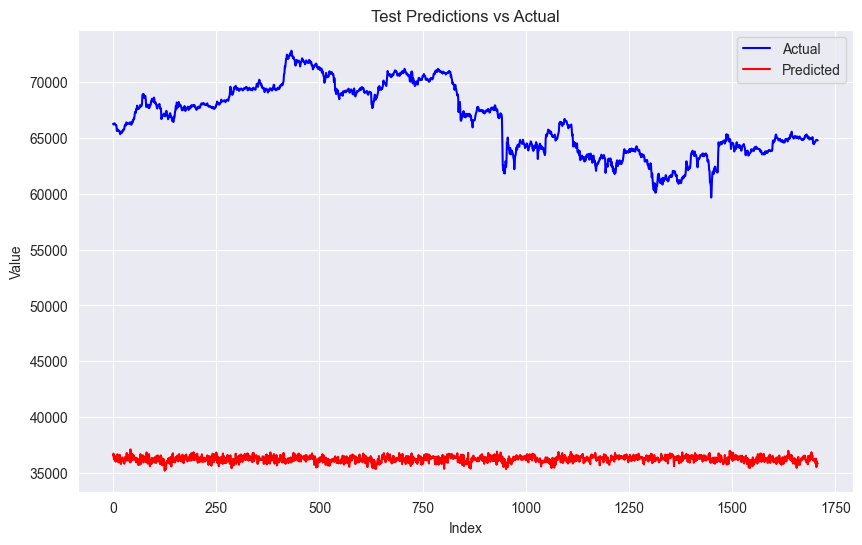

In [104]:
y_pred = np.squeeze(model.predict(test_seq_x))
plot_predictions(test_seq_y, y_pred)

<a id=3.3.3></a>
### 3.3.3 RESNET-FCN

In [124]:
class ResNetFCN(Model):
    def __init__(self, c_in, c_out):
        super(ResNetFCN, self).__init__()
        nf = 128
        kss=[7, 5, 5]

        # Define ResBlock
        class ResBlock(tf.keras.layers.Layer):
            def __init__(self, ni, nf, kss):
                super(ResBlock, self).__init__()
                self.convblock1 = tf.keras.Sequential([
                    tf.keras.layers.Conv1D(nf, kss[0], padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU()
                ])
                self.convblock2 = tf.keras.Sequential([
                    tf.keras.layers.Conv1D(nf, kss[1], padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU()
                ])
                self.convblock3 = tf.keras.Sequential([
                    tf.keras.layers.Conv1D(nf, kss[2], padding='same'),
                    tf.keras.layers.BatchNormalization()
                ])

                # expand channels for the sum if necessary
                self.shortcut = tf.keras.layers.BatchNormalization() if ni == nf else tf.keras.layers.Conv1D(nf, 1, padding='same')
                self.add = tf.keras.layers.Add()
                self.act = tf.keras.layers.ReLU()

            def call(self, x):
                res = x
                x = self.convblock2(x)
                x = self.convblock3(x)
                x = self.add([x, self.shortcut(res)])
                x = self.act(x)
                return x

        # Initialize ResBlocks
        self.resblock1 = ResBlock(c_in, nf, kss=kss)
        self.resblock2 = ResBlock(nf, nf * 2, kss=kss)
        self.resblock3 = ResBlock(nf * 2, nf * 2, kss=kss)
        self.gap = tf.keras.layers.GlobalAveragePooling1D()
        self.fc = tf.keras.layers.Dense(c_out)

    def call(self, x):
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.gap(x)
        return self.fc(x)

In [125]:
# Initialize and build the model
model = ResNetFCN(input_shape, num_classes)


optim = tf.keras.optimizers.Adam(learning_rate=2e-4)
# Compile the model
model.compile(optimizer=optim, loss='mean_squared_error', metrics=['mse'])

# Train the model
history = model.fit(train_seq_x, train_seq_y, validation_data=(val_seq_x, val_seq_y), epochs=100, batch_size=64,
                    callbacks=[early_stopping, lr_scheduler], verbose=1)

# Evaluate the model
test_preds = model.predict(test_seq_x)
test_loss = model.evaluate(test_seq_x, test_seq_y, verbose=0)

print("RESNET-FCN Root Mean Squared Error of Test Data:", np.sqrt(test_loss))

Epoch 1/100


C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\layer.py:361: UserWarning: `build()` was called on layer 'res_block_23', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\layer.py:361: UserWarning: `build()` was called on layer 'res_block_24', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\l

487/487 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - loss: 25682639847424.0000 - mse: 25682639847424.0000 - val_loss: 42258731008.0000 - val_mse: 42258731008.0000 - learning_rate: 2.0000e-04
Epoch 2/100
425/487 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 14405542912.0000 - mse: 14405542912.0000

KeyboardInterrupt: 

In [ ]:
plot_predictions(test_seq_y, test_preds)